In [1]:
pip install torch torchvision matplotlib

  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/108.7 kB ? eta -:--:--
     --- ------------------------------------ 10.2/108.7 kB ? eta -:--:--
     ---------- -------------------------- 30.7/108.7 kB 435.7 kB/s eta 0:00:01
     --------------------------------- -- 102.4/108.7 kB 980.4 kB/s eta 0:00:01
     ------------------------------------ 108.7/108.7 kB 703.6 kB/s eta 0:00:00
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
# --- Importaciones del sistema y configuración de la ruta ---
import sys
import os
import warnings
import numpy as np
import torch
import matplotlib.pyplot as plt

# Añadir el directorio raíz del proyecto al path para poder importar los módulos
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    
print(f"Project root añadido al path: {PROJECT_ROOT}")

# --- Importaciones del framework de ataque ---
from models.pytorch import PyTorchModel
from attacks.carlini_wagner import CarliniWagnerL2Attack
from criteria import Misclassification, TargetClass
from distances import MeanSquaredDistance as MSE
from utils import imagenet_example, softmax

# Ignorar advertencias de pre-entrenamiento de torchvision
warnings.filterwarnings("ignore", category=UserWarning)

Project root añadido al path: c:\Users\ADMIN\Desktop\cw-attack-pca-copia


In [30]:
# 1. Cargar el modelo pre-entrenado de PyTorch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

# Usamos torch.hub para evitar problemas de versión con 'pretrained'
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True).to(device)
model.eval()

# 2. WRAPPEAR EL MODELO
# Definimos los valores de preprocesamiento para imágenes en rango [0, 255]
mean_vals = np.array([0.485, 0.456, 0.406])
std_vals = np.array([0.229, 0.224, 0.225])

# Creamos el wrapper del modelo.
# 'channel_axis=1' es crucial para que el wrapper sepa que PyTorch
# usa el formato (N, C, H, W).
fmodel = PyTorchModel(
    model,
    bounds=(0, 255),
    num_classes=1000,
    channel_axis=1,  
    preprocessing=(mean_vals * 255, std_vals * 255),
    device=device
)

Usando dispositivo: cpu


Using cache found in C:\Users\ADMIN/.cache\torch\hub\pytorch_vision_v0.10.0


Dimensiones de la imagen: (224, 224, 3), Tipo: float32
Etiqueta original (ground truth): 282
Predicción del modelo sobre la imagen original: 285
El modelo no clasifica correctamente la imagen original. El ataque puede no ser significativo.


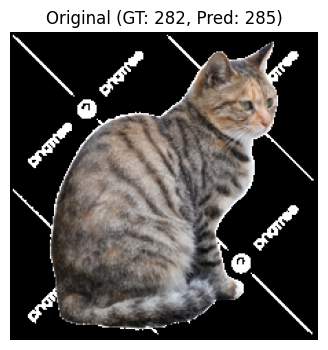

In [35]:
# Cargar la imagen de ejemplo. La función devuelve una imagen NumPy (H, W, C)
image, label = imagenet_example()
print(f"Dimensiones de la imagen: {image.shape}, Tipo: {image.dtype}") # Debe ser (224, 224, 3)
print(f"Etiqueta original (ground truth): {label}")

# 2. Verificar la predicción del modelo sobre la imagen original
# fmodel.predictions() espera una imagen NumPy y devuelve logits y si es adversarial (aquí no aplica)
predictions = fmodel.predictions(image) # Solo devuelve un valor
original_pred_label = np.argmax(predictions)

print(f"Predicción del modelo sobre la imagen original: {original_pred_label}")

# Asegurémonos de que el modelo clasifica correctamente la imagen antes del ataque
if original_pred_label != label:
    print("El modelo no clasifica correctamente la imagen original. El ataque puede no ser significativo.")

# Mostrar la imagen original
plt.figure(figsize=(4, 4))
plt.imshow(image.astype(np.uint8))
plt.title(f"Original (GT: {label}, Pred: {original_pred_label})")
plt.axis('off')
plt.show()

In [36]:
from adversarial import Adversarial

# 1. Crear el objeto Adversarial. Este objeto contiene toda la información
# necesaria para que el ataque funcione.
criterion = Misclassification()
# El ataque de C&W L2 minimiza la distancia L2, por lo que usamos MSE.
distance = MSE

adversarial = Adversarial(
    fmodel,
    criterion,
    image,
    label,
    distance=distance
)

# 2. Inicializar y ejecutar el ataque
# Usamos parámetros más rápidos para la prueba. Para mejores resultados,
# aumenta binary_search_steps y max_iterations.
attack = CarliniWagnerL2Attack()
attack(adversarial,
       binary_search_steps=8,
       max_iterations=100,
       confidence=0,
       learning_rate=1e-3)


array([[[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [255., 255., 255.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       ...,

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,  

¡Ataque exitoso!
Predicción original: 282
Predicción adversarial: 285
Distancia (MSE normalizada): 0.0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17380\1035556760.py:16: RuntimeWarning: invalid value encountered in divide
  perturbation_vis = (perturbation_vis / perturbation_vis.max() * 255).astype(np.uint8)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17380\1035556760.py:16: RuntimeWarning: invalid value encountered in cast
  perturbation_vis = (perturbation_vis / perturbation_vis.max() * 255).astype(np.uint8)


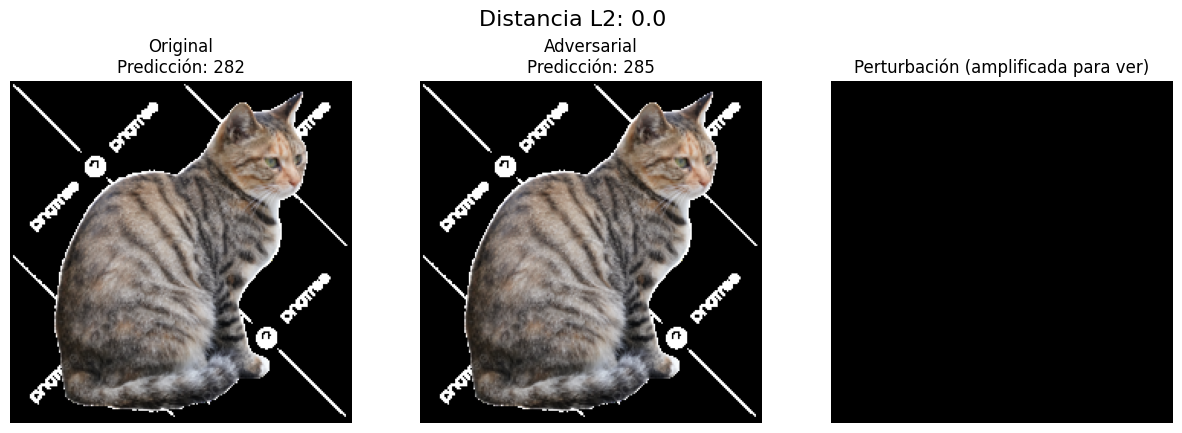

In [37]:
def show_images(original_np, adversarial_np, original_label, adversarial_label, distance):
    """Función para visualizar la imagen original, la adversarial y la perturbación."""
    if adversarial_np is None:
        print("El ataque no encontró un ejemplo adversarial.")
        return

    # Convertir a uint8 para visualización
    original_vis = original_np.astype(np.uint8)
    adversarial_vis = np.clip(adversarial_np, 0, 255).astype(np.uint8)

    # Calcular la perturbación y normalizarla para que sea visible
    perturbation = adversarial_np - original_np
    
    # Opción 1: Mostrar la perturbación absoluta
    perturbation_vis = np.abs(perturbation)
    perturbation_vis = (perturbation_vis / perturbation_vis.max() * 255).astype(np.uint8)
    
    # Opción 2 (más informativa): Mostrar la perturbación re-escalada
    # perturbation_vis = (perturbation + abs(perturbation.min()))
    # perturbation_vis = (perturbation_vis / perturbation_vis.max() * 255).astype(np.uint8)


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original_vis)
    axes[0].set_title(f"Original\nPredicción: {original_label}")
    axes[0].axis('off')

    axes[1].imshow(adversarial_vis)
    axes[1].set_title(f"Adversarial\nPredicción: {adversarial_label}")
    axes[1].axis('off')
    
    axes[2].imshow(perturbation_vis)
    axes[2].set_title("Perturbación (amplificada para ver)")
    axes[2].axis('off')

    plt.suptitle(f"Distancia L2: {distance}", fontsize=16)
    plt.show()

# --- Mostrar resultados ---
if adversarial.image is not None:
    print("¡Ataque exitoso!")
    print(f"Predicción original: {adversarial.original_class}")
    print(f"Predicción adversarial: {adversarial.adversarial_class}")
    print(f"Distancia (MSE normalizada): {adversarial.distance.value}")
    
    show_images(
        adversarial.original_image,
        adversarial.image,
        adversarial.original_class,
        adversarial.adversarial_class,
        adversarial.distance.value
    )
else:
    print("El ataque falló. No se encontró un ejemplo adversarial con los parámetros dados.")
    print("Intenta aumentar 'max_iterations' o 'binary_search_steps'.")